# cGAN con EMNIST

Se importan las bibliotecas necesarias para el proyecto. Aquí se incluyen:

    numpy para manejo numérico.

    os para operaciones del sistema de archivos.

    matplotlib.pyplot para visualización de imágenes.

    tensorflow y tensorflow_datasets para construcción de modelos y carga de datasets.

    random para control de aleatoriedad.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import random

2025-04-25 09:49:56.016290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745596196.187046    1138 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745596196.230656    1138 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 09:49:56.641248: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Se carga el dataset EMNIST Letters desde tensorflow_datasets, que contiene imágenes de letras manuscritas.

as_supervised=True devuelve tuplas (imagen, etiqueta).

with_info=True permite obtener metadatos del dataset.

Se dividen en conjunto de entrenamiento y prueba por facilidad aunque no se use el de prueba.

In [2]:
ds_name = "emnist/letters"
(ds_train, ds_test), ds_info = tfds.load(
    ds_name,
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True, 
    with_info=True
)

I0000 00:00:1745596205.368249    1138 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Se define una función preprocess que normaliza la imagen y la transforma visualmente para que quede orientada correctamente.

El dataset se preprocesa, se divide en batches y se optimiza con prefetch.

Luego se convierte todo el dataset de entrenamiento a arrays de NumPy para ser usado más fácilmente fuera de la API de TensorFlow.

In [3]:
def preprocess(image, label):
    # Normaliza a [0, 1]
    image = (tf.cast(image, tf.float32)-127.5) / 127.5
    # Rota 90° e invierte horizontalmente (para que se vea bien)
    image = tf.image.flip_left_right(image)
    image = tf.image.rot90(image)

    return image, label

batch_size = 128
ds_train1 = ds_train.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
x_train, y_train = next(iter(ds_train1.unbatch().batch(100000)))
x_train = x_train.numpy()
y_train = y_train.numpy()
y_train = y_train.astype(np.uint8)


2025-04-25 09:50:05.884027: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Se muestra una imagen aleatoria del conjunto de entrenamiento (x_train). Esto sirve para verificar visualmente las imágenes preprocesadas.

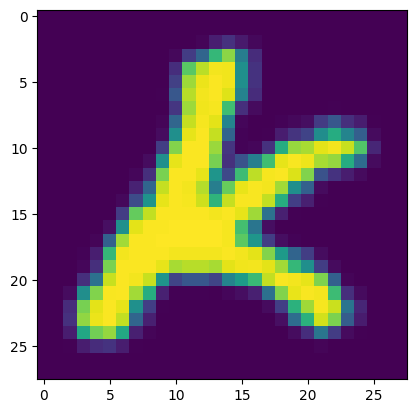

In [4]:
plt.imshow(x_train[random.randint(0,50000)])

## Definicion Generador
Esta función crea un modelo generador para la cGAN (Red Generativa Antagónica Condicional):

Empieza con una capa Dense para transformar un vector latente (LATENT_DIM).

Usa UpSampling2D y Conv2D para escalar hasta una imagen de 28x28.

Se concatena una representación embebida de la etiqueta con el vector latente.

La salida es una imagen generada condicionada a una clase.

Se guarda un diagrama del modelo si no existe.


In [ ]:
MODEL_OUTPUT_PATH = '/home/galo/Diplomado/python/TF/Proyecto/Codigo'
LATENT_DIM = 100

def define_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128*7*7, activation='relu', input_dim=LATENT_DIM),
        tf.keras.layers.Reshape((7, 7, 128)),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(momentum=0.8),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(momentum=0.8),
        tf.keras.layers.Conv2D(1, 3, padding='same', activation='tanh')
    ])
    z = tf.keras.layers.Input(shape=(LATENT_DIM,))
    label = tf.keras.layers.Input(shape=(1,), dtype='uint8')
    label_embed = tf.keras.layers.Embedding(input_dim=26, output_dim=LATENT_DIM)(label)
    label_embed = tf.keras.layers.Flatten()(label_embed)
    combined = tf.keras.layers.multiply([z, label_embed])

    img = model(combined)

    return tf.keras.models.Model([z, label], img)

def get_g_model():
    g_model = define_generator()
    g_model.summary()
    return g_model

g_model = get_g_model()


/home/galo/Diplomado/python/TF/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 100)    │      3,700 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 100)       │          0 │ input_layer_1[0]… │
│                     │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 28, 28, 1) │    856,193 │ multiply[0][0]    │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 859,893 (3.28 MB)

 Trainable params: 859,509 (3.28 MB)

 Non-trainable params: 384 (1.50 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Definicion Discriminador
Crea un modelo discriminador que recibe una imagen y una etiqueta:

La etiqueta se embebe y se convierte en un "mapa de etiquetas" de tamaño (28,28,1).

Este mapa se concatena con la imagen.

El modelo evalúa si la imagen es real o generada, condicionada a la etiqueta.

También se guarda un diagrama del modelo.

In [ ]:
def define_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), 2, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, (3, 3), 2, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    img = tf.keras.layers.Input(shape=(28, 28, 1))
    label = tf.keras.layers.Input(shape=(1,))
    label_embed = tf.keras.layers.Embedding(input_dim=26, output_dim=np.prod((28, 28)))(label)
    label_embed = tf.keras.layers.Flatten()(label_embed)
    label_embed = tf.keras.layers.Reshape((28, 28, 1))(label_embed)
    concatenated = tf.keras.layers.Concatenate(axis=-1)([label_embed, img])
    prediction = model(concatenated)
    return tf.keras.models.Model([img, label], prediction)

def get_d_model():
    d_model = define_discriminator()
    d_model.summary()

    return d_model

d_model = get_d_model()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 784)    │     29,008 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 784)       │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 28, 28, 1) │          0 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28, 2) │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 1)         │  1,625,761 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,654,769 (6.31 MB)

 Trainable params: 1,654,769 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Definicion CGAN
Combina el generador y discriminador en una cGAN:

El discriminador se congela (no se entrena en este paso).

La entrada es el vector latente y la etiqueta.

El objetivo es que el generador engañe al discriminador.

Se compila el modelo y se guarda su arquitectura.

In [ ]:
def get_cgan_model():

    d_model.compile(loss='binary_crossentropy', metrics=[
        'accuracy'], optimizer='adam')

    z = tf.keras.layers.Input(shape=(100,))
    label = tf.keras.layers.Input(shape=(1,))
    img = g_model([z, label])

    d_model.trainable = False
    prediction = d_model([img, label])
    cgan = tf.keras.models.Model([z, label], prediction)
    cgan.compile(loss='binary_crossentropy',
                 optimizer='adam', metrics=['accuracy'])
    cgan.summary()

    return cgan, d_model, g_model

cgan, d_model, g_model = get_cgan_model()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 28, 28, 1) │    859,893 │ input_layer_6[0]… │
│ (Functional)        │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 1)         │  1,654,769 │ functional_1[0][… │
│ (Functional)        │                   │            │ input_layer_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,514,662 (9.59 MB)

 Trainable params: 859,509 (3.28 MB)

 Non-trainable params: 1,655,153 (6.31 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Entrenamiento 
Entrena la cGAN por EPOCHS épocas:

Se generan imágenes falsas con el generador y se entrenan ambas redes por separado.

El discriminador aprende a distinguir entre reales y falsas.

El generador intenta mejorar engañando al discriminador.

Cada SAVE_INTERVAL épocas, se visualizan ejemplos generados.

Se almacenan las pérdidas de ambas redes.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Losses(d,g): 0.35386595 [array(2.4382935, dtype=float32), array(0.29553372, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


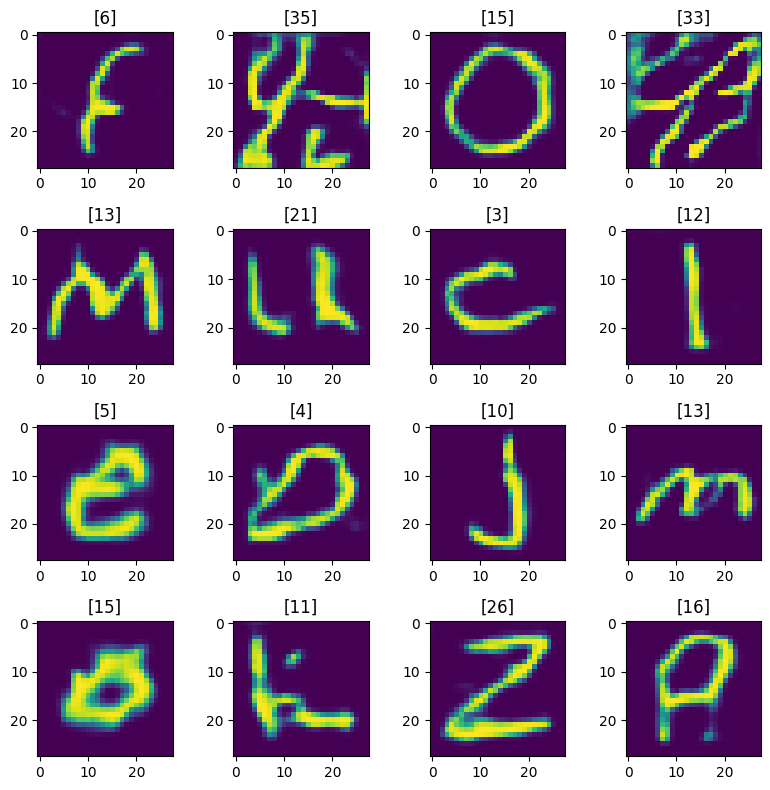

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━

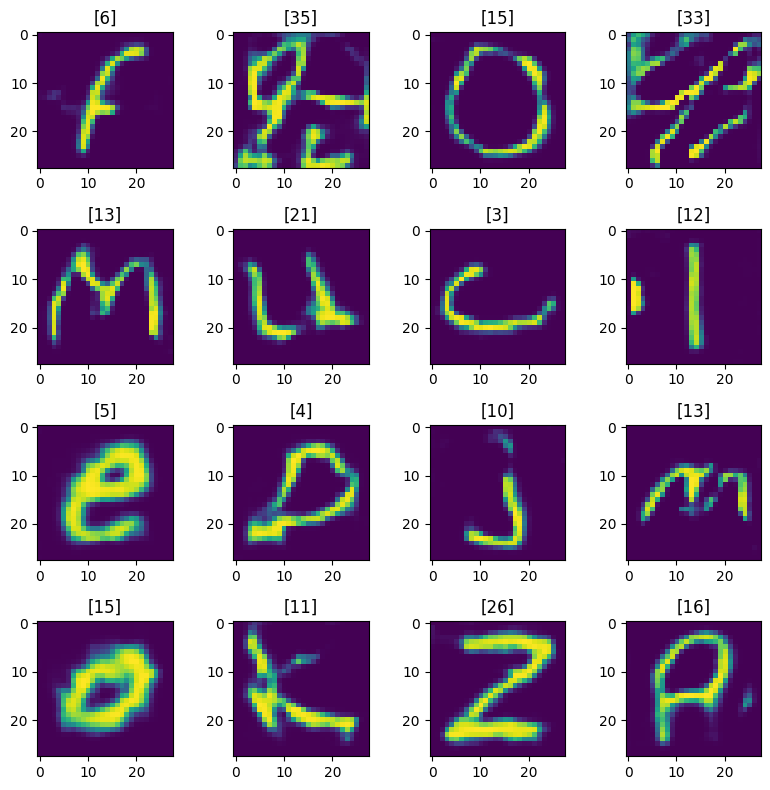

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━

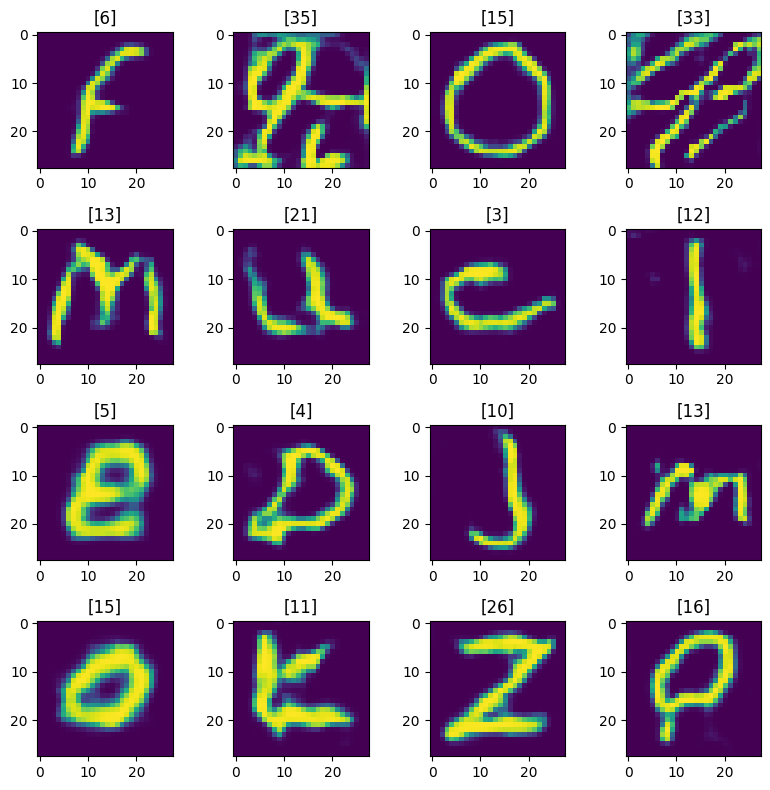

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━

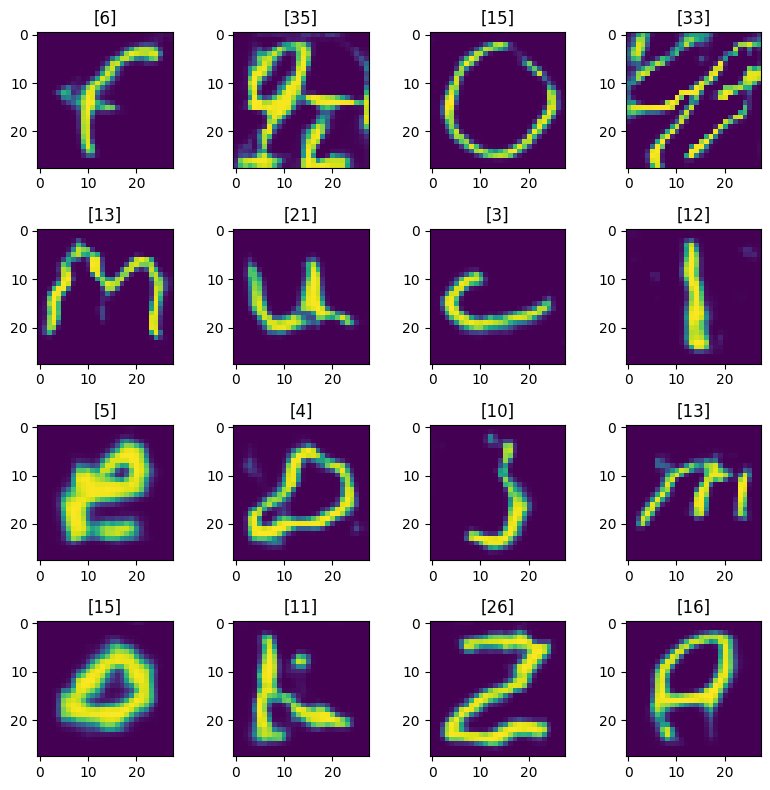

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━

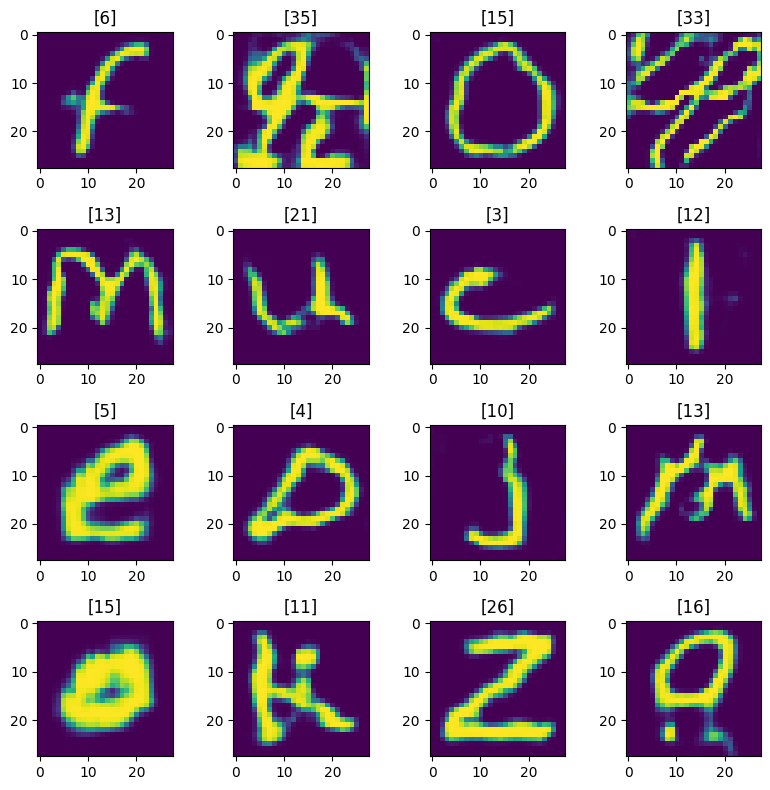

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━

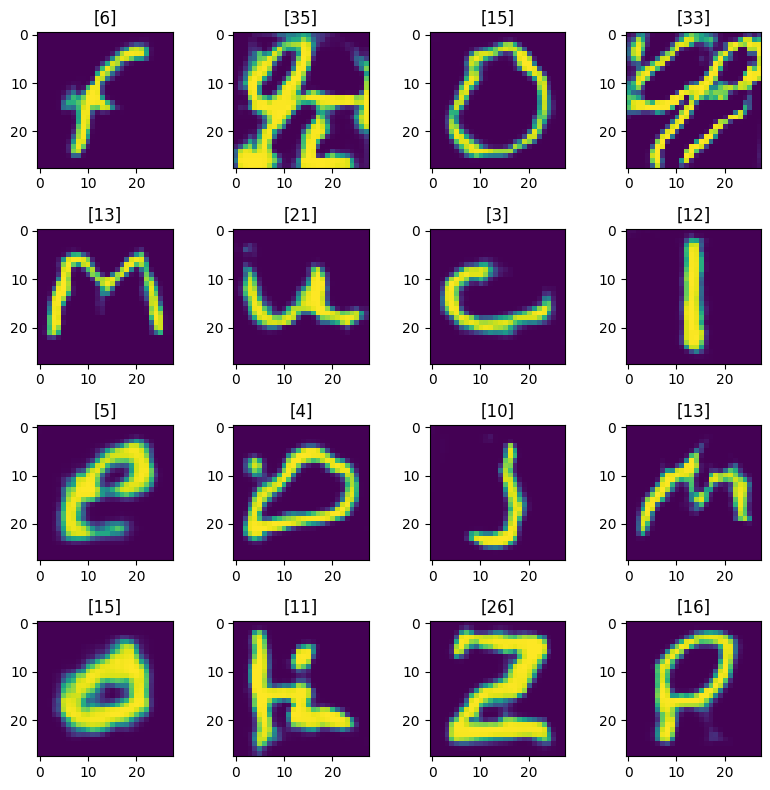

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━

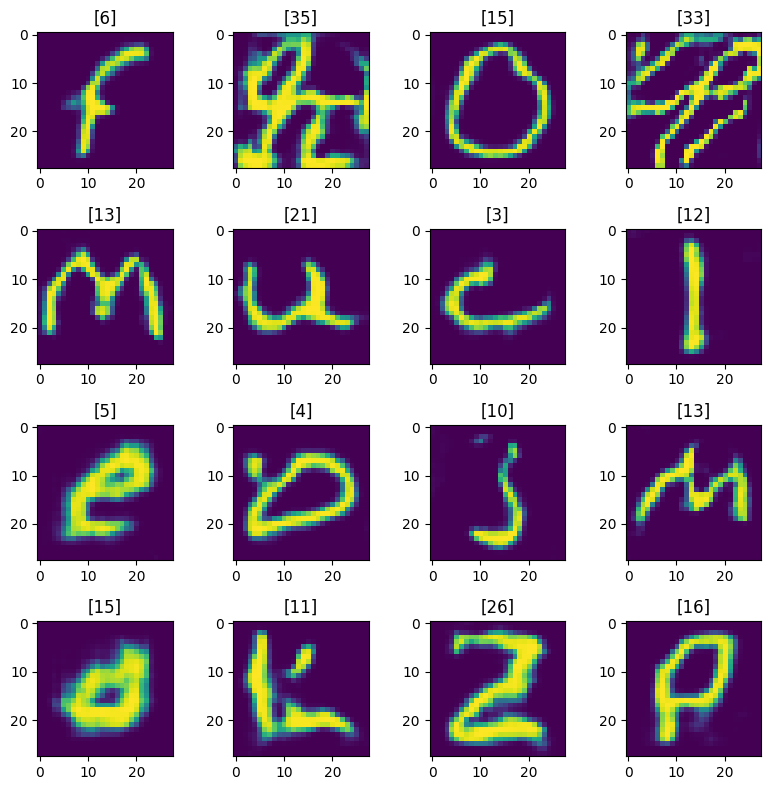

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━

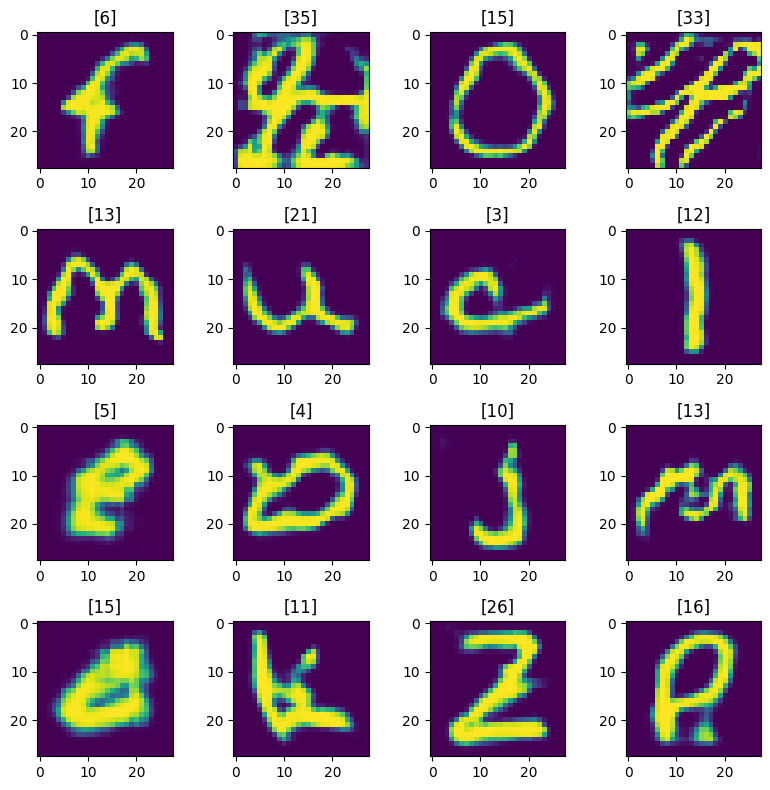

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━

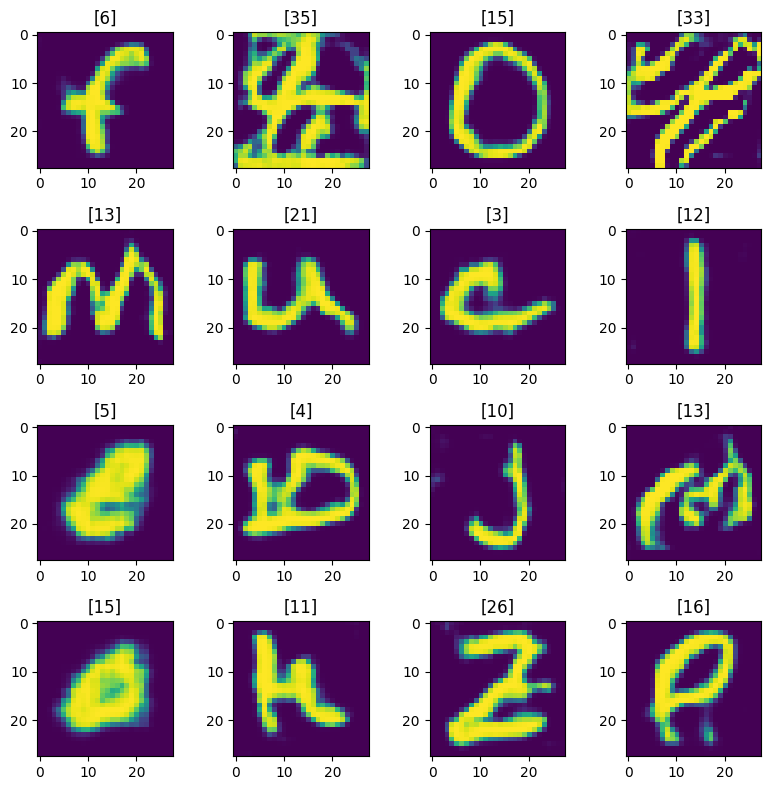

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━

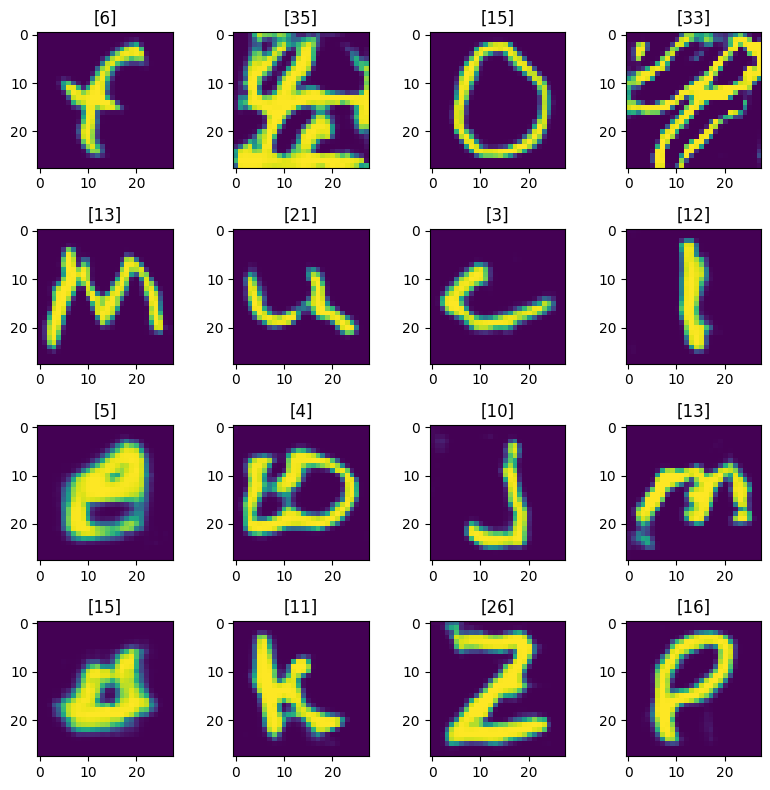

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━

In [34]:
EPOCHS = 10000
BATCH_SIZE = 128
SAVE_INTERVAL = 1000

def plot_image(images, labels, rows, cols):
    fig = plt.figure(figsize=(8, 8))
    for i in range(1, cols*rows + 1):
        img = images[i-1]
        ax = fig.add_subplot(rows, cols, i)
        ax.title.set_text(labels[i-1])
        plt.imshow(img.reshape((28, 28)))
    fig.tight_layout()
    plt.show()

def train_model():
    valid = np.ones((BATCH_SIZE, 1))
    fake = np.zeros((BATCH_SIZE, 1))

    losses = {"G": [], "D": []}

    samples_test = np.random.normal(0, 1, (16, 100))
    labels_test = np.random.randint(0, 26, 16).reshape((-1, 1))

    for epoch in range(EPOCHS):
        idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
        real_imgs, labels = x_train[idx], y_train[idx]
        noise = np.random.normal(0, 1, (BATCH_SIZE, 100))
        fake_imgs = g_model.predict([noise, labels])

        d_model.trainable = True
        d_loss_real = d_model.train_on_batch([real_imgs, labels], valid)
        d_loss_fake = d_model.train_on_batch([fake_imgs, labels], fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        d_model.trainable = False

        z = np.random.normal(0, 1, size=(BATCH_SIZE, 100))
        labels = np.random.randint(0, 26, BATCH_SIZE).reshape((-1, 1))

        g_loss = cgan.train_on_batch([z, labels], valid)

        losses["G"].append(g_loss)
        losses["D"].append(d_loss)
        if epoch % SAVE_INTERVAL == 0:
            print("Losses(d,g):", d_loss[0], g_loss)
            results = g_model.predict([samples_test, labels_test])
            plot_image(results, labels_test, 4, 4)
    
    return cgan, d_model, g_model

cgan, d_model, g_model = train_model()

Guarda los modelos generador, discriminador y la cGAN completa en archivos .keras.

In [35]:
CGAN_MODEL_NAME = 'CGAN_MODEL_NAME'
D_MODEL_NAME = 'D_MODEL_NAME'
G_MODEL_NAME = 'G_MODEL_NAME'

def save_model():
    os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
    cgan.save(os.path.join(MODEL_OUTPUT_PATH, f'{CGAN_MODEL_NAME}.keras'))
    d_model.save(os.path.join(MODEL_OUTPUT_PATH, f'{D_MODEL_NAME}.keras'))
    g_model.save(os.path.join(MODEL_OUTPUT_PATH, f'{G_MODEL_NAME}.keras'))

save_model()

## Visualizacion
Se genera una imagen con una etiqueta específica (index = 37) y se visualiza. Es útil para ver cómo el generador produce una letra concreta del dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


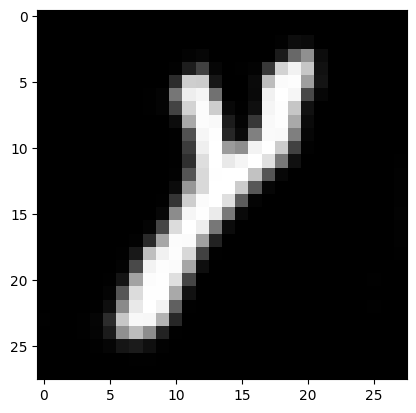

In [58]:
index = 25
samples_test = np.random.normal(0, 1, (1, 100))
labels_test = np.array([int(index)]).reshape((-1, 1))
results = g_model.predict([samples_test, labels_test])
plt.imshow(results[0].reshape(28, 28), cmap='gray')

Diccionario

In [37]:
num_char = {
    1: 'A',
    2: 'B',
    3: 'C',
    4: 'D',
    5: 'E',
    6: 'F',
    7: 'G',
    8: 'H',
    9: 'I',
    10: 'J',
    11: 'K',
    12: 'L',
    13: 'M',
    14: 'N',
    15: 'O',
    16: 'P',
    17: 'Q',
    18: 'R',
    19: 'S',
    20: 'T',
    21: 'U',
    22: 'V',
    23: 'W',
    24: 'X',
    25: 'Y',
    26: 'Z',
    27: 'a',
    28: 'b',
    29: 'd',
    30: 'e',
    31: 'f',
    32: 'g',
    33: 'h',
    34: 'n',
    35: 'q',
    36: 'r',
    37: 't'
}

char_num = {v: k for k, v in num_char.items()}


Esta función recibe una lista de imágenes y las concatena en una sola imagen grande:

Si por_filas=True, une todas horizontalmente.

Si por_filas=False, las organiza en una cuadrícula.

Si no se indica columnas, calcula automáticamente una distribución cuadrada.

Para mostrar el resultado del modelo ya como "palabra".

In [38]:
def unir_imagenes(imagenes, por_filas=True, columnas=None):
    imagenes = [np.squeeze(img) for img in imagenes]
    alto, ancho = imagenes[0].shape

    if por_filas:
        return np.hstack(imagenes)
    else:
        if columnas is None:
            columnas = int(np.ceil(np.sqrt(len(imagenes))))
        filas = int(np.ceil(len(imagenes) / columnas))
        imagen_compuesta = np.zeros((filas * alto, columnas * ancho), dtype=imagenes[0].dtype)
        for idx, img in enumerate(imagenes):
            f = idx // columnas
            c = idx % columnas
            imagen_compuesta[f*alto:(f+1)*alto, c*ancho:(c+1)*ancho] = img
        return imagen_compuesta

Como ejemplo usaremos la palabra 'HOLA', y se mostrara como imagen ya escrita

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


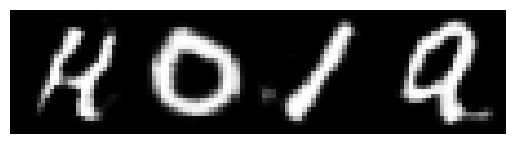

In [59]:
palabra = 'HOLA'
imagenes = []
for i in palabra:
    samples_test = np.random.normal(0, 1, (1, 100))
    labels_test = np.array([char_num[i]]).reshape((-1, 1))
    results = g_model.predict([samples_test, labels_test])
    imagenes.append(results[0].reshape(28,28))

# Ejemplo de uso: crear 5 imágenes distintas
#imagenes = [np.full((28, 28), i * 50, dtype=np.uint8) for i in range(5)]

# Unir en una fila
imagen_unida = unir_imagenes(imagenes, por_filas=True)

# Mostrar
plt.imshow(imagen_unida, cmap='gray')
plt.axis('off')
plt.show()